<h2>Results from varying CH4 and Cl2</h2>

In [1]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import importlib
import types

# Very important lines to run the setup notebooks!!!
%run do_plot_setup.ipynb
%run do_radical_count_setup.ipynb
get_cl_radical_budget = get_cl_radical_budget # Tautology to get rid of the yellow underlines
import cl2_utilities as cl2_utils


# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

In [2]:
# Load data for the Cl2 sweep trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
exps = ["09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data['experiment_name']=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | # Use exp. with 100 ppm Cl2 tank for Cl2 5-30 ppm and exp. with 1000 ppm Cl2 tank for 45-90 ppm.
                                  (conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']>40)] # Proxy for >=45 ppm is a Cl2 measurement of more than 85mV
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)
current_data.conversion_data = conversion_data
current_data.bypass_data = bypass_data

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = np.array([1000 if b>40 else 100 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']]) # We've confirmed that in this subset of trials, only Cl2 conc's 45 and over used the 1000 ppm Cl2 tank

# Extract the values and 95% CI from the CH4 conversion data
current_data.ch4_baselines = conversion_data["Selected: CH4 (ppm) baseline"]
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)
current_data.ch4_per_cl = current_data.ch4_conversions/current_data.cl_budget
current_data.ch4_per_cl_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.ch4_conversions,current_data.ch4_95_ci,current_data.cl_budget,current_data.cl_budget_95_ci)

# Save to variable and report success
cl2_sweep_data = current_data
print("Loaded results for plotting into object 'cl2_sweep_data'.")

Loaded results for plotting into object 'cl2_sweep_data'.


In [3]:
# Load data for the 1:1 sweep trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
exps = ["09-28-24 Vary Cl2 and CH4 1-to-1 (45-90 ppm)","09-19-24 Sweep 1-to-1 Cl2 and CH4 (10-20 ppm)","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4",
         "12-16-24 Sweep Cl2, 5ppm CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]

# The next few lines are necessary to map the 5-ppm data point to the correct bypass period
# This is necessary because on this one trial, we manually set the sampling windows instead of using the autofinder 
bypass_data.closest_start_time = bypass_data.closest_start_time.replace(268, 1e6)
bypass_data.loc[bypass_data['bypass_start'] == 242.35, 'closest_start_time'] = 268
bypass_data.bypass_start = bypass_data.bypass_start.replace(242.35, 280)
# Done

conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data["experiment_name"]!="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | (abs(conversion_data["Cl2 LabJack: Cl2 reading minus zero (mV) baseline"]-30)<2)] # We want to exclude the less-precise, redundant 30 ppm trials from this sweep.
conversion_data = conversion_data[(conversion_data["experiment_name"]!="12-16-24 Sweep Cl2, 2ppm CH4") | (conversion_data.start_time==207.3)] # We only want to grab one data point from this experiment
conversion_data = conversion_data[(conversion_data["experiment_name"]!="12-16-24 Sweep Cl2, 5ppm CH4") | (conversion_data.start_time==268)] # We only want to grab one data point from thsi experiment
# The 1:1 sweep skipped 30 ppm since it's the common base-case that we already had; now we'll add it back in.
base_case_bypass = all_bypass_data[((all_bypass_data.experiment_name=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4")&(all_bypass_data.closest_start_time==212.48))]
base_case_conversion = all_conversion_data[((all_conversion_data.experiment_name=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4")&(all_conversion_data.start_time==212.48))]
bypass_data = pd.concat([base_case_bypass,bypass_data])
conversion_data = pd.concat([base_case_conversion,conversion_data])
conversion_data=conversion_data.sort_values(by='Selected: CH4 (ppm) baseline',ascending=True)

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [20,100,100,100,1000,1000,1000]

# Extract the values and 95% CI from the CH4 conversion data
current_data.ch4_baselines = conversion_data["Selected: CH4 (ppm) baseline"]
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)
current_data.ch4_per_cl = current_data.ch4_conversions/current_data.cl_budget
current_data.ch4_per_cl_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.ch4_conversions,current_data.ch4_95_ci,current_data.cl_budget,current_data.cl_budget_95_ci)

# Save to variable and report success
one_to_one_sweep_data = current_data
print("Loaded results for plotting into object 'one_to_one_sweep_data'.")

Loaded results for plotting into object 'one_to_one_sweep_data'.


In [4]:
# Load data for the humidity trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
exp_name = '12-10-24 Humidity Sweep'
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]==exp_name]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]==exp_name]
conversion_data = conversion_data.tail(7)

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [1000]*conversion_data.shape[0]

# Get the humidity
start_times = conversion_data['start_time']
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
humidities = [float(means[means.closest_start_time==t]['Humidity Probe: Rel. Humidity (%)']) for t in start_times] #Lookup the correct entry in the groupby
current_data.humidities = [v*(1.0/(1-6.0/200.0)) for v in humidities] # Scale appropriately to adjust for added chlorine flow

# Extract the values and 95% CI from the CH4 conversion data
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)
current_data.ch4_per_cl = current_data.ch4_conversions/current_data.cl_budget
current_data.ch4_per_cl_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.ch4_conversions,current_data.ch4_95_ci,current_data.cl_budget,current_data.cl_budget_95_ci)

# Save to variable and report success
humidity_sweep_data = current_data
print("Loaded results for plotting into object 'humidity_sweep_data'.")

Loaded results for plotting into object 'humidity_sweep_data'.


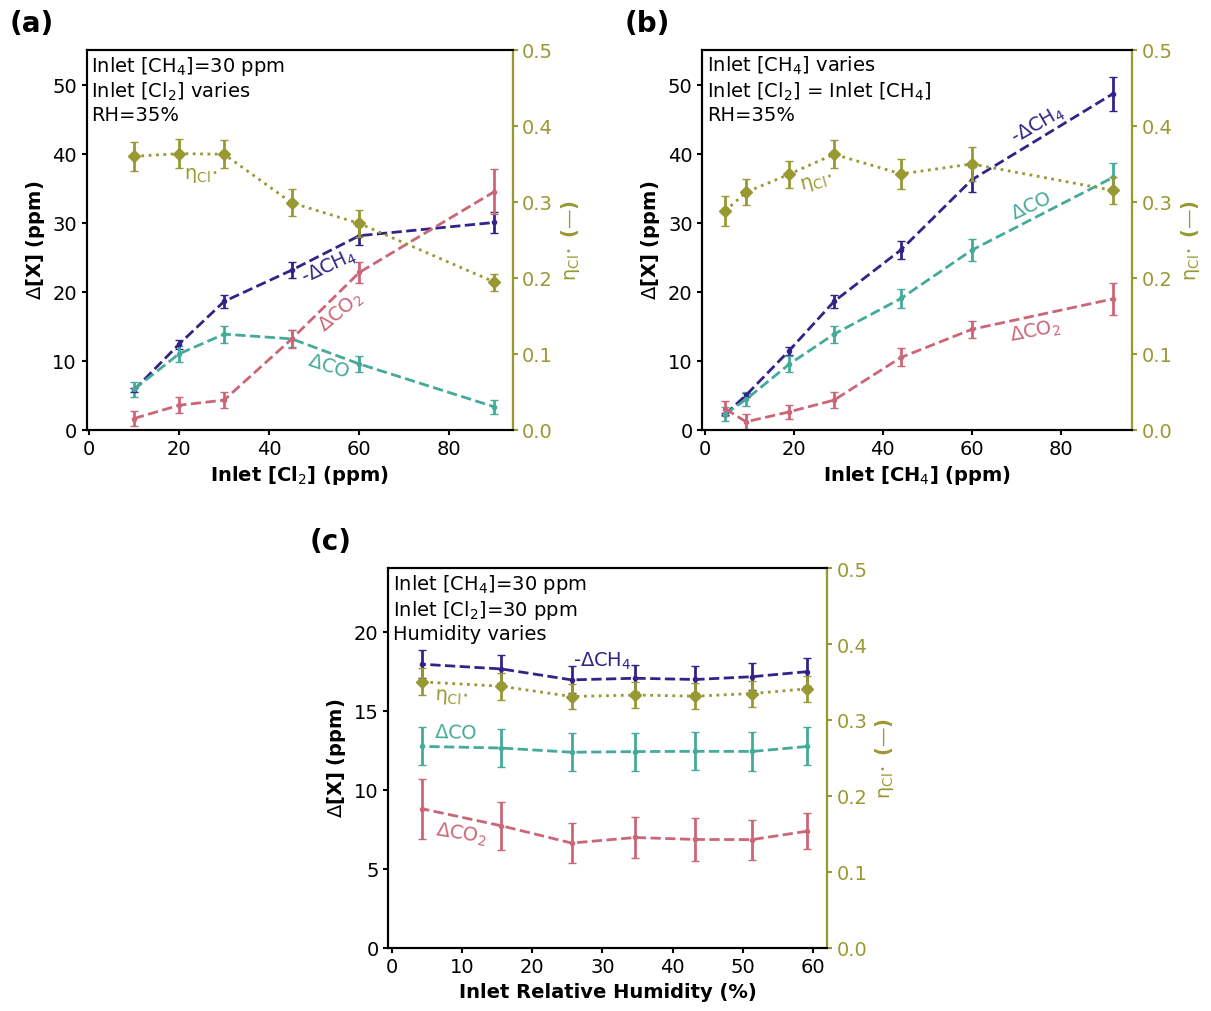

In [32]:
# Global settings
use_error_bars = True

# Set up axes
fig = plt.figure(figsize=(plot_default_properties['figure_width'],10))
gs = GridSpec(4, 4, figure=fig)
ax_a = plt.subplot(gs[:2, :2])
ax_b = plt.subplot(gs[:2, 2:])
ax_c = plt.subplot(gs[2:, 1:3])

#ax_a = fig.add_subplot(gs[0, 0])
#ax_b = fig.add_subplot(gs[0, 1])
#ax_c = fig.add_subplot(gs[1, :])

ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_a_right = ax_a.twinx()
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_b_right = ax_b.twinx()
ax_c.text(-0.18,1.05, "\n(c)", transform=ax_c.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_c_right = ax_c.twinx()

# Plot the lines and set the axis labels, the same for all axes
for (current_data, current_axis, current_axis_right, x_vals) in zip((cl2_sweep_data,one_to_one_sweep_data,humidity_sweep_data),
                                                                    (ax_a,ax_b,ax_c),(ax_a_right,ax_b_right,ax_c_right),
                                                                    (cl2_sweep_data.inlet_cl2, one_to_one_sweep_data.ch4_baselines, humidity_sweep_data.humidities)):
    
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CH4',x_vals,current_data.ch4_conversions,(current_data.ch4_95_ci if use_error_bars else None))
    #cl2_utils.do_error_bar(current_axis,line_default_properties,'Cl2',x_vals,current_data.cl2_conversions,(current_data.cl2_conversion_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CO',x_vals,current_data.co,(current_data.co_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CO2',x_vals,current_data.co2,(current_data.co2_95_ci if use_error_bars else None))
    #cl2_utils.do_error_bar(current_axis,line_default_properties,'CH2O',x_vals,current_data.ch2o,(current_data.ch2o_95_ci if use_error_bars else None))
    #cl2_utils.do_error_bar(current_axis,line_default_properties,'C1 Sum',x_vals,current_data.co_co2_ch2o_sum,(current_data.co_co2_ch2o_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis_right,line_default_properties,'Cl* Efficiency',x_vals,current_data.ch4_per_cl,(current_data.ch4_per_cl_95_ci if use_error_bars else None))

    current_axis.set_ylabel("$\Delta$[X] (ppm)",fontweight=plot_default_properties['font_weight'])
    current_axis.xaxis.set_tick_params(labelbottom=True)
    current_axis_right.set_ylabel(line_default_properties['Cl* Efficiency']['text']+" (—)",fontweight=plot_default_properties['font_weight'])
    current_axis_right.xaxis.set_tick_params(labelbottom=True)
    right_ax_color = line_default_properties['Cl* Efficiency']['color']
    current_axis_right.tick_params(axis='y', colors=right_ax_color)
    current_axis_right.yaxis.label.set_color(right_ax_color)
    current_axis_right.spines['right'].set_color(right_ax_color)
    current_axis.set_xlim(left=-0.5)
    

# Manually set axis limits and labels where needed
ax_a.set_ylim(0,55)
ax_b.set_ylim(0,55)
ax_c.set_ylim(0,24)
ax_a_right.set_ylim(0,0.5)
ax_b_right.set_ylim(0,0.5)
ax_c_right.set_ylim(0,0.5)
ax_a.set_xlabel("Inlet [Cl$_2$] (ppm)",fontweight=plot_default_properties['font_weight'])
ax_b.set_xlabel("Inlet [CH$_4$] (ppm)",fontweight=plot_default_properties['font_weight'])
ax_c.set_xlabel("Inlet Relative Humidity (%)",fontweight=plot_default_properties['font_weight'])

# Labeling part (a)
labels_a = (('CH4',46.5,20.5,25),
          ('CO2',50,13.5,40),
          ('CO',48,7,-18),
          ('Cl* Efficiency',21,35.5,0))
cl2_utils.label_lines(ax_a,line_default_properties,labels_a)
ax_a.text(0.01,0.99,"Inlet [CH$_4$]=30 ppm\nInlet [Cl$_2$] varies\nRH=35%",transform=ax_a.transAxes,ha='left',va='top')

# Labeling part (b)
labels_b = (('CH4',68,40.8,30),
          ('CO2',68,12,11),
          ('CO',68,30,25),
          ('Cl* Efficiency',21,34,15))
cl2_utils.label_lines(ax_b,line_default_properties,labels_b)
ax_b.text(0.01,0.99,"Inlet [CH$_4$] varies\nInlet [Cl$_2$] = Inlet [CH$_4$]\nRH=35%",transform=ax_b.transAxes,ha='left',va='top')

# Labeling part (c)
labels_c = (('CH4',25.8,17.5,0),
          ('CO2',6,6.3,-9),
          ('CO',6,13,-1.5),
          ('Cl* Efficiency',6,15.2,-3))
cl2_utils.label_lines(ax_c,line_default_properties,labels_c)
ax_c.text(0.01,0.99,"Inlet [CH$_4$]=30 ppm\nInlet [Cl$_2$]=30 ppm\nHumidity varies",transform=ax_c.transAxes,ha='left',va='top')

for ax in [ax_a, ax_a_right, ax_b, ax_b_right, ax_c, ax_c_right]:
    ax.tick_params(width=plot_default_properties['box_linewidth'])
    for spine in ax.spines.values():
        spine.set_linewidth(plot_default_properties['box_linewidth'])    

plt.savefig('exported_images/vary_ch4_cl2_results.png', bbox_inches='tight',dpi=300)
plt.show()